In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("drive/MyDrive/nlp_data/raw/cleaned_data.csv")
data

,movie,genre,plot,preprocessed_plot
0,Doctor Strange in the Multiverse of Madness,"Action,Adventure,Fantasy",Doctor Strange teams up with a mysterious teen...,doctor strange team mysterious teenage girl dr...
1,Avatar: The Way of Water,"Action,Adventure,Sci-Fi",Jake Sully lives with his newfound family form...,jake sully life newfound family formed planet ...
2,The Northman,"Action,Adventure,Drama",From visionary director Robert Eggers comes Th...,visionary director robert egger come northman ...
3,Moon Knight,"Action,Adventure,Fantasy",Steven Grant discovers he's been granted the p...,steven grant discovers granted power egyptian ...
4,The Batman,"Action,Crime,Drama",When a sadistic serial killer begins murdering...,sadistic serial killer begin murdering key pol...
...,...,...,...,...
31158,La vie et la passion de Jésus Christ,"Short,Biography,Drama",The story of Jesus Christ from the proclamatio...,story jesus christ proclamation nativity cruci...
31159,Life of the Party: The Story of Beatrice,"Biography,Drama",This made-for-television movie is a dramatizat...,made television movie dramatization life found...
31160,Adventures in Rock,"Documentary,Biography,Music",This Canadian documentary follows the journey ...,canadian documentary follows journey toronto b...
31161,The Girl in White,"Biography,Drama",A young woman decides to become a doctor at a ...,young woman decides become doctor time woman m...


In [ ]:
data["genre"] = data["genre"].str.split(',')

In [ ]:
data["genre"][:5]

0    [Action, Adventure, Fantasy]
1     [Action, Adventure, Sci-Fi]
2      [Action, Adventure, Drama]
3    [Action, Adventure, Fantasy]
4          [Action, Crime, Drama]
Name: genre, dtype: object

In [ ]:
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
)
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 24930
Number of rows in test set: 6233


In [ ]:
terms = tf.ragged.constant(train_df["genre"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Animation', 'Biography', 'Horror', 'Romance', 'Thriller', 'Mystery', 'Fantasy', 'Sci-Fi', 'Family', 'Documentary', 'History', 'Short', 'Music', 'Sport', 'War', 'Musical', 'Western', 'Film-Noir', 'Reality-TV', 'Game-Show', 'Talk-Show', 'News', 'Adult']


In [ ]:
sample_label = train_df["genre"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Crime', 'Drama', 'Mystery']
Label-binarized representation: [[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genre"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["preprocessed_plot"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Plot: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Plot: b'hendrik sixteen big city kid vexed learn mother moving little brother eddi village south austria make matter worse local'
Label(s): ['Horror' 'Thriller' 'Mystery']
 
Plot: b'game pick conclusion psychonauts rhombus ruin following zanotto rescue team return psychonaut headquarters raz discovers'
Label(s): ['Comedy' 'Action' 'Adventure']
 
Plot: b'dee dee blanchard overprotective daughter gypsy trying escape toxic relationship mother gypsy quest independence open pandora box secret ultimately lead murder'
Label(s): ['Drama' 'Crime' 'Biography']
 
Plot: b'female lawyer take accused wife murderer client find morally compelled betray one way another'
Label(s): ['Drama' 'Crime' 'Thriller']
 
Plot: b'resident friendly pennsylvania town foil three brother plan rob bank christmas eve'
Label(s): ['Comedy' 'Adventure' 'Crime']
 


In [ ]:
vocabulary = set()
train_df["preprocessed_plot"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

30802


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
model = Sequential()
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(lookup.vocabulary_size(), activation='sigmoid'))

In [ ]:
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

In [ ]:
history = model.fit(train_dataset, epochs=20)

Epoch 1/20
195/195 [==============================] - 47s 231ms/step - loss: 0.2126 - categorical_accuracy: 0.4161
Epoch 2/20
195/195 [==============================] - 38s 195ms/step - loss: 0.0877 - categorical_accuracy: 0.4485
Epoch 3/20
195/195 [==============================] - 40s 205ms/step - loss: 0.0262 - categorical_accuracy: 0.4513
Epoch 4/20
195/195 [==============================] - 38s 193ms/step - loss: 0.0088 - categorical_accuracy: 0.5021
Epoch 5/20
195/195 [==============================] - 37s 192ms/step - loss: 0.0050 - categorical_accuracy: 0.5284
Epoch 6/20
195/195 [==============================] - 39s 200ms/step - loss: 0.0035 - categorical_accuracy: 0.5432
Epoch 7/20
195/195 [==============================] - 37s 190ms/step - loss: 0.0031 - categorical_accuracy: 0.5497
Epoch 8/20
195/195 [==============================] - 37s 189ms/step - loss: 0.0027 - categorical_accuracy: 0.5584
Epoch 9/20
195/195 [==============================] - 37s 189ms/step - loss: 0.0

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15771136  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 29)                7453      
                                                                 
Total params: 15,909,917
Trainable params: 15,909,917
Non-trainable params: 0
_________________________________________________________________
None


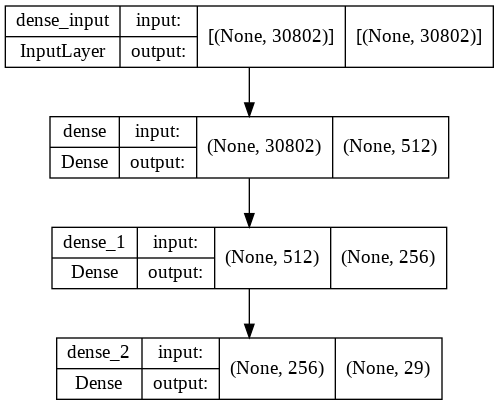

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

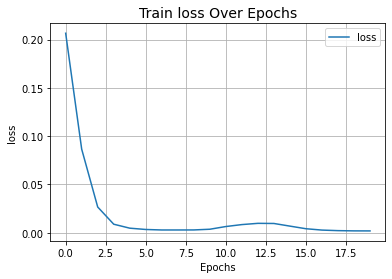

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.title("Train {} Over Epochs".format('loss'), fontsize=14)
plt.legend()
plt.grid()
plt.show()

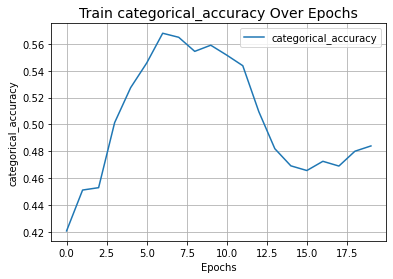

In [ ]:
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel("Epochs")
plt.ylabel('categorical_accuracy')
plt.title("Train {} Over Epochs".format('categorical_accuracy'), fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
_, categorical_acc = model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

49/49 [==============================] - 1s 10ms/step - loss: 0.7119 - categorical_accuracy: 0.3571
Categorical accuracy on the test set: 35.71%.
